In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 파일 경로를 이용해서 폴더별 이미지 불러오기

In [3]:
import pathlib

In [4]:
data_dir = 'C:/Users/Song/python/travel_images2'

In [5]:
data_dir

'C:/Users/Song/python/travel_images2'

In [6]:
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/Song/python/travel_images2')

In [7]:
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

35093


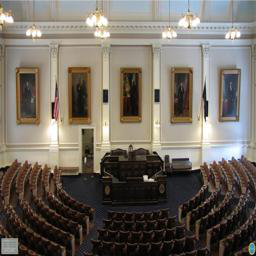

In [8]:
travel = list(data_dir.glob('travel and  adventure/*'))
PIL.Image.open(str(travel[0]))

## 데이터셋 만들기

In [9]:
batch_size = 32
img_height = 150
img_width = 150

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 35093 files belonging to 4 classes.
Using 28075 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 35093 files belonging to 4 classes.
Using 7018 files for validation.


In [12]:
val_ds

<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int32)>

In [13]:
class_names = train_ds.class_names
print(class_names)

['architecure', 'art and culture', 'food and d rinks', 'travel and  adventure']


## 데이터 시각화

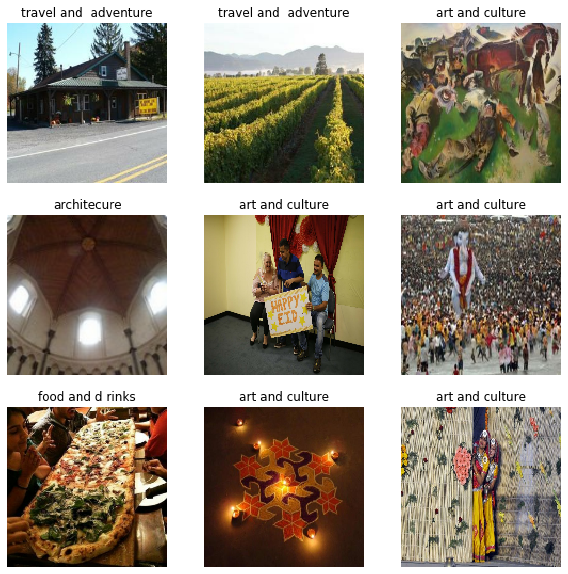

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32,)


## 성능을 높이도록 데이터세트 구성

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터 표준화 하기

In [17]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9804631


## 모델 만들기

In [19]:
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
 
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(rate=0.3),
  layers.Dense(64, activation='relu'),
  layers.Dropout(rate=0.3),
  layers.Dense(16, activation='relu'),
  layers.Dropout(rate=0.3),
    
  layers.Dense(num_classes, activation='softmax')
])

## 모델 컴파일하기

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )

## 모델 훈련

In [21]:
es=EarlyStopping(patience=3, restore_best_weights=True)
cp=ModelCheckpoint('best_travel_cnn.h5')
history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es, cp],
  epochs=20
)

Epoch 1/20
878/878 [==============================] - 163s 185ms/step - loss: 1.0195 - accuracy: 0.5650 - val_loss: 0.6415 - val_accuracy: 0.7716
Epoch 2/20
878/878 [==============================] - 151s 172ms/step - loss: 0.6375 - accuracy: 0.7772 - val_loss: 0.8388 - val_accuracy: 0.7093
Epoch 3/20
878/878 [==============================] - 153s 174ms/step - loss: 0.5198 - accuracy: 0.8255 - val_loss: 0.4052 - val_accuracy: 0.8596
Epoch 4/20
878/878 [==============================] - 154s 175ms/step - loss: 0.4394 - accuracy: 0.8519 - val_loss: 0.4202 - val_accuracy: 0.8552
Epoch 5/20
878/878 [==============================] - 153s 174ms/step - loss: 0.3880 - accuracy: 0.8713 - val_loss: 0.3947 - val_accuracy: 0.8618
Epoch 6/20
878/878 [==============================] - 150s 170ms/step - loss: 0.3151 - accuracy: 0.8978 - val_loss: 0.4192 - val_accuracy: 0.8598
Epoch 7/20
878/878 [==============================] - 156s 177ms/step - loss: 0.2670 - accuracy: 0.9125 - val_loss: 0.4223 -

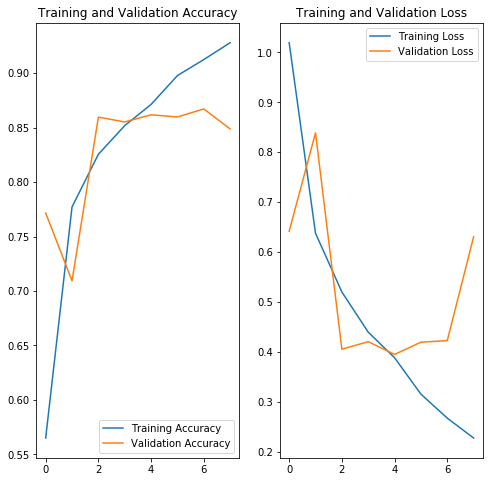

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()